In [718]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

In [719]:
BATCH_SIZE = 10

In [720]:
class ImgFolder(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        origin_data = process(self.imgs[data])
        transform_data = transform(origin_data)
        return origin_data, transform_data, label

In [721]:


transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

dataset = tv.datasets.ImageFolder("./data", transform=transform)

num_elsa = Counter(dataset.targets)[0]
num_not_elsa = Counter(dataset.targets)[1]
num_datapoints = num_not_elsa + num_elsa
print("Elsa: ", num_elsa)
print("Not Elsa: ", num_not_elsa)
dataset

Elsa:  618
Not Elsa:  26123


Dataset ImageFolder
    Number of datapoints: 26741
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [722]:
def weight_unbalanced(images, nclasses):
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

In [723]:
weights = torch.tensor([num_elsa, num_not_elsa])
#weights = weights.double()
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)


tensor([0.0231, 0.9769])
tensor([0.9769, 0.0231])


In [724]:
target = np.hstack((np.zeros(int(num_not_elsa), dtype=np.int32),
                    np.ones(int(num_elsa), dtype=np.int32)))

class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1./class_sample_count
samples_weight = np.array([weight[t] for t in target])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()

sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

In [725]:
trainset, testset = torch.utils.data.random_split(dataset, [21000, 5741])
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=BATCH_SIZE, num_workers=1)

classes = ("elsa", "not_elsa")

In [726]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

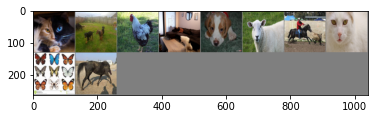

not_elsa not_elsa not_elsa  elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa


In [727]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(tv.utils.make_grid(images))
print(' '.join("%5s" % classes[labels[j]] for j in range(BATCH_SIZE)))

In [728]:
classes[labels[0]]

'not_elsa'

In [729]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(13456,1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return x


In [730]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(13456,1024)
        self.fc2 = nn.Linear(1024, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [731]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4608, 512),
            nn.Linear(512, 64),
            nn.Linear(64, 16),
            nn.Linear(16, 2),
        )


    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [732]:
net1 = Net1()
path1 = "./models/model1.pth"

net2 = Net2()
path2 = "./models/model3.pth"

net = Net3()
path = "./models/model4.pth"

print(net1)
print(net2)
print(net)

Net1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=13456, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)
Net2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
Net3(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): 

In [733]:
print(weights)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

tensor([0.9769, 0.0231])


In [734]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0

100%|██████████| 2100/2100 [03:20<00:00, 10.47it/s]


In [735]:
torch.save(net.state_dict(), path)

In [736]:
net = Net3()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

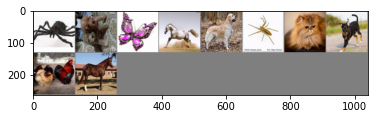

GroundTruth:  not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa


In [737]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(tv.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(BATCH_SIZE)))

In [738]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(BATCH_SIZE)))

Predicted:  not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa not_elsa


In [739]:
correct = 0
total = 0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for j, data in enumerate(tqdm(testloader, 0)):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(2):
            
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
            except:
                label = labels
                class_correct[label] += c.item()
            class_total[label] += 1

print("Accuracy: %d %%" % (100 * correct / total))
for i in range(2):
    print("Accuracy of %5s : %2d %%" % (classes[i], 100*class_correct[i] /class_total[i]))

100%|██████████| 575/575 [00:46<00:00, 12.48it/s]Accuracy: 94 %
Accuracy of  elsa : 71 %
Accuracy of not_elsa : 95 %

